In [1]:
# Essential imports for data science and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configure visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Environment Setup:")
print(f"   Device: {device}")
print(f"   PyTorch Version: {torch.__version__}")
print(f"   Pandas Version: {pd.__version__}")
print(f"   NumPy Version: {np.__version__}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("\n✅ All libraries imported successfully!")
print("📊 Ready to begin customer churn analysis...")

🚀 Environment Setup:
   Device: cpu
   PyTorch Version: 2.8.0+cpu
   Pandas Version: 2.3.3
   NumPy Version: 2.3.3

✅ All libraries imported successfully!
📊 Ready to begin customer churn analysis...


In [3]:
# Load the customer churn dataset
print("📥 Loading Cleaned Telco Customer Churn dataset...")

data_paths = [
    '../data/processed/clean-processed-data.csv'
]

df = None
for path in data_paths:
    try:
        df = pd.read_csv(path)
        print(f"✅ Cleaned Data loaded successfully from: {path}")
        break
    except FileNotFoundError:
        continue

# Display basic information about the dataset
print(f"\n📊 Dataset Overview:")
print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display first few rows
print(f"\n👀 First 5 rows:")
print(df.head())

📥 Loading Cleaned Telco Customer Churn dataset...
✅ Cleaned Data loaded successfully from: ../data/clean-processed-data.csv

📊 Dataset Overview:
   Shape: 7,043 rows × 22 columns
   Memory usage: 6.4 MB

👀 First 5 rows:
   Unnamed: 0  customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0           0  7590-VHVEG  Female              0     Yes         No       1   
1           1  5575-GNVDE    Male              0      No         No      34   
2           2  3668-QPYBK    Male              0      No         No       2   
3           3  7795-CFOCW    Male              0      No         No      45   
4           4  9237-HQITU  Female              0      No         No       2   

  PhoneService MultipleLines InternetService  ... DeviceProtection  \
0           No            No             DSL  ...               No   
1          Yes            No             DSL  ...              Yes   
2          Yes            No             DSL  ...               No   
3           No           

In [4]:
# Comprehensive Exploratory Data Analysis
print("📊 EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# Convert Churn to binary for analysis
df_eda = df.copy()
df_eda['Churn_Binary'] = (df_eda['Churn'] == 'Yes').astype(int)
churn_rate = df_eda['Churn_Binary'].mean()

print(f"🎯 Overall Churn Rate: {churn_rate:.1%}")
print(f"📈 Business Impact: {churn_rate * len(df_eda):.0f} customers churned")

📊 EXPLORATORY DATA ANALYSIS
🎯 Overall Churn Rate: 26.5%
📈 Business Impact: 1869 customers churned


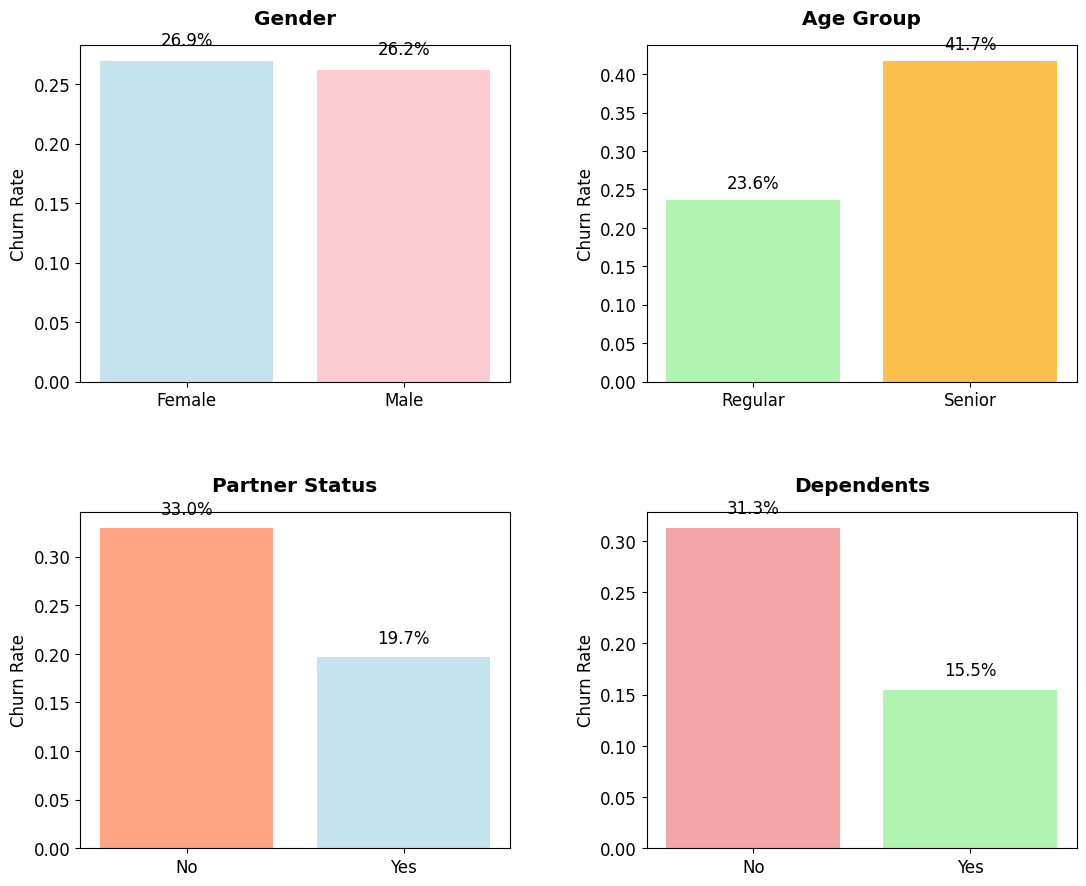

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gender
gender_churn = df_eda.groupby('gender')['Churn_Binary'].mean()
bars = axs[0, 0].bar(gender_churn.index, gender_churn.values, alpha=0.7, color=['lightblue', 'lightpink'])
axs[0, 0].set_title('Gender', fontweight='bold', pad=15)
axs[0, 0].set_ylabel('Churn Rate')
for bar, rate in zip(bars, gender_churn.values):
    axs[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{rate:.1%}', ha='center', va='bottom')

# Senior Citizen
senior_churn = df_eda.groupby('SeniorCitizen')['Churn_Binary'].mean()
senior_labels = ['Regular', 'Senior']
bars = axs[0, 1].bar(senior_labels, senior_churn.values, alpha=0.7, color=['lightgreen', 'orange'])
axs[0, 1].set_title('Age Group', fontweight='bold', pad=15)
axs[0, 1].set_ylabel('Churn Rate')
for bar, rate in zip(bars, senior_churn.values):
    axs[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{rate:.1%}', ha='center', va='bottom')

# Partner
partner_churn = df_eda.groupby('Partner')['Churn_Binary'].mean()
bars = axs[1, 0].bar(partner_churn.index, partner_churn.values, alpha=0.7, color=['coral', 'lightblue'])
axs[1, 0].set_title('Partner Status', fontweight='bold', pad=15)
axs[1, 0].set_ylabel('Churn Rate')
for bar, rate in zip(bars, partner_churn.values):
    axs[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{rate:.1%}', ha='center', va='bottom')

# Dependents
dependents_churn = df_eda.groupby('Dependents')['Churn_Binary'].mean()
bars = axs[1, 1].bar(dependents_churn.index, dependents_churn.values, alpha=0.7, color=['lightcoral', 'lightgreen'])
axs[1, 1].set_title('Dependents', fontweight='bold', pad=15)
axs[1, 1].set_ylabel('Churn Rate')
for bar, rate in zip(bars, dependents_churn.values):
    axs[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{rate:.1%}', ha='center', va='bottom')

plt.tight_layout(pad=4.0)  # Extra padding for clarity
plt.show()


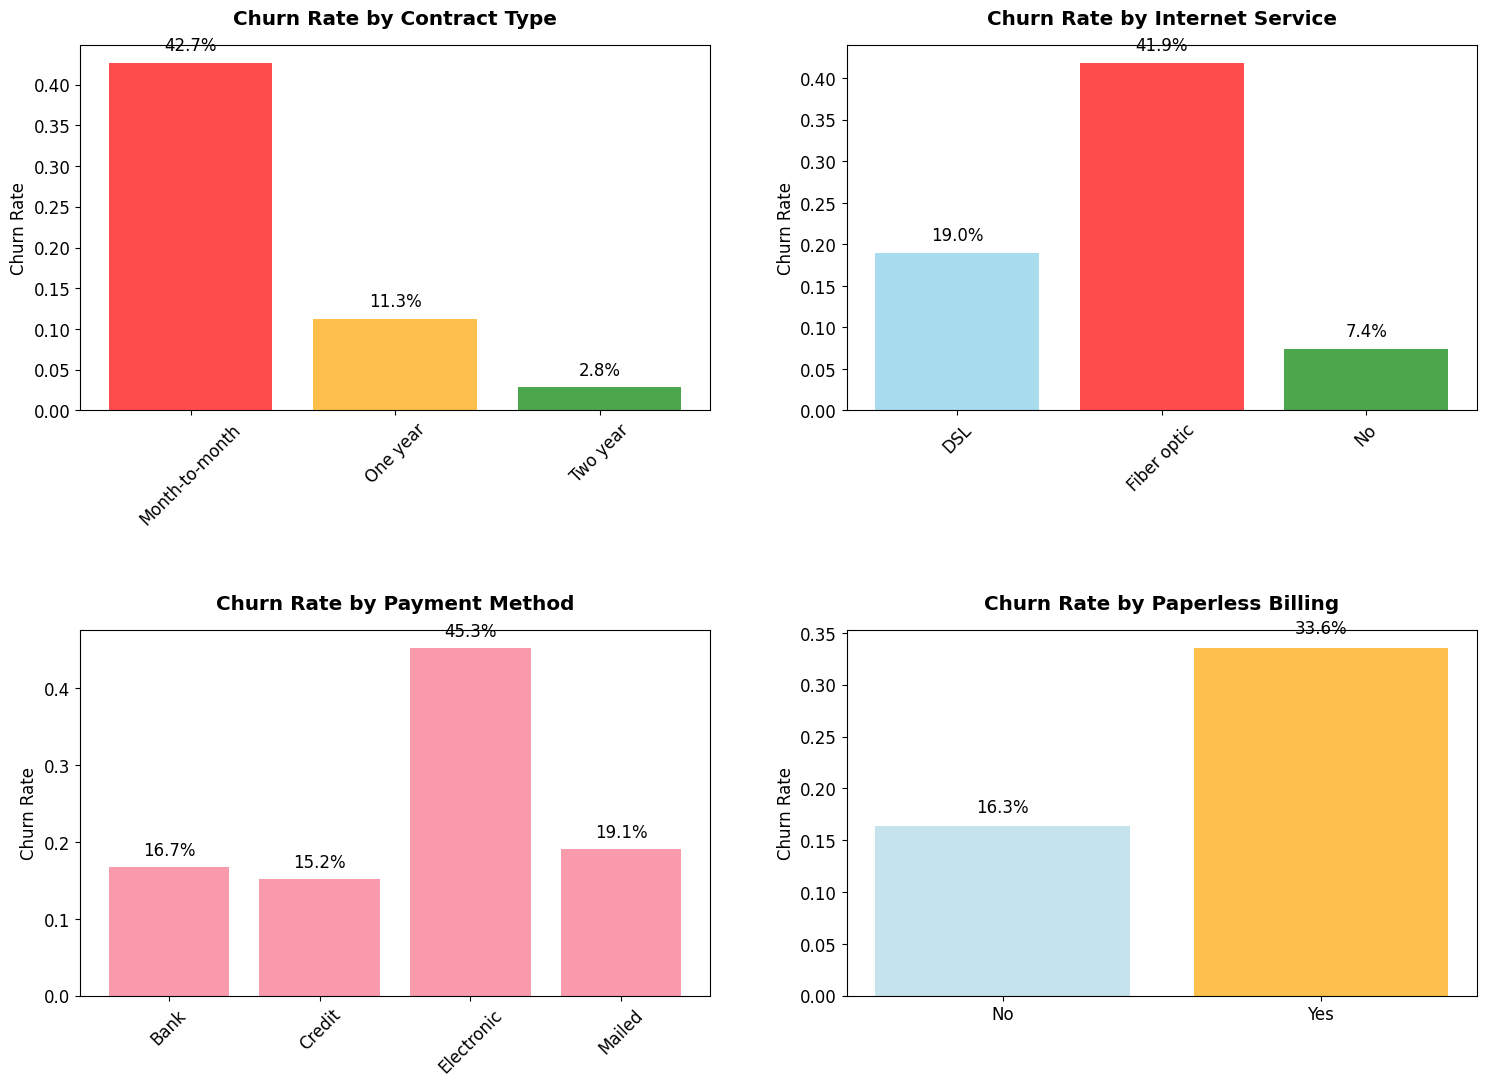

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Large figure, 2 by 2 grid

# Contract Type
contract_churn = df_eda.groupby('Contract')['Churn_Binary'].mean()
bars = axs[0, 0].bar(range(len(contract_churn)), contract_churn.values, alpha=0.7,
                     color=['red', 'orange', 'green'])
axs[0, 0].set_title('Churn Rate by Contract Type', fontweight='bold', pad=15)
axs[0, 0].set_ylabel('Churn Rate')
axs[0, 0].set_xticks(range(len(contract_churn)))
axs[0, 0].set_xticklabels(contract_churn.index, rotation=45)
for bar, rate in zip(bars, contract_churn.values):
    axs[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{rate:.1%}', ha='center', va='bottom')

# Internet Service
internet_churn = df_eda.groupby('InternetService')['Churn_Binary'].mean()
bars = axs[0, 1].bar(range(len(internet_churn)), internet_churn.values, alpha=0.7,
                     color=['skyblue', 'red', 'green'])
axs[0, 1].set_title('Churn Rate by Internet Service', fontweight='bold', pad=15)
axs[0, 1].set_ylabel('Churn Rate')
axs[0, 1].set_xticks(range(len(internet_churn)))
axs[0, 1].set_xticklabels(internet_churn.index, rotation=45)
for bar, rate in zip(bars, internet_churn.values):
    axs[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{rate:.1%}', ha='center', va='bottom')

# Payment Method
payment_churn = df_eda.groupby('PaymentMethod')['Churn_Binary'].mean()
bars = axs[1, 0].bar(range(len(payment_churn)), payment_churn.values, alpha=0.7)
axs[1, 0].set_title('Churn Rate by Payment Method', fontweight='bold', pad=15)
axs[1, 0].set_ylabel('Churn Rate')
axs[1, 0].set_xticks(range(len(payment_churn)))
axs[1, 0].set_xticklabels([method.split()[0] for method in payment_churn.index], rotation=45)
for bar, rate in zip(bars, payment_churn.values):
    axs[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{rate:.1%}', ha='center', va='bottom')

# Paperless Billing
paperless_churn = df_eda.groupby('PaperlessBilling')['Churn_Binary'].mean()
bars = axs[1, 1].bar(paperless_churn.index, paperless_churn.values, alpha=0.7, color=['lightblue', 'orange'])
axs[1, 1].set_title('Churn Rate by Paperless Billing', fontweight='bold', pad=15)
axs[1, 1].set_ylabel('Churn Rate')
for bar, rate in zip(bars, paperless_churn.values):
    axs[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{rate:.1%}', ha='center', va='bottom')

plt.tight_layout(pad=4.0)
plt.show()


3️⃣ Analyzing Numerical Variables vs Churn...


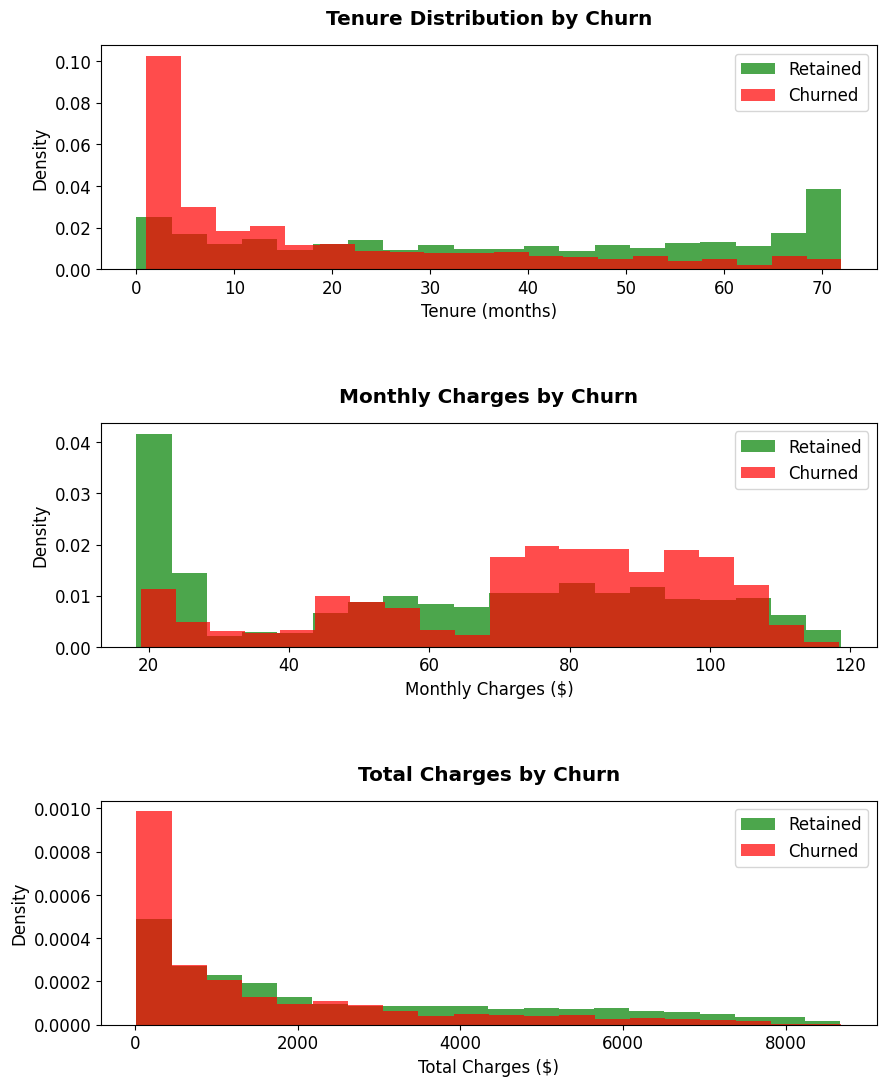

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

print(f"3️⃣ Analyzing Numerical Variables vs Churn...")

# Tenure Distribution
churned = df_eda[df_eda['Churn'] == 'Yes']['tenure']
retained = df_eda[df_eda['Churn'] == 'No']['tenure']
axs[0].hist(retained, bins=20, alpha=0.7, label='Retained', color='green', density=True)
axs[0].hist(churned, bins=20, alpha=0.7, label='Churned', color='red', density=True)
axs[0].set_title('Tenure Distribution by Churn', fontweight='bold', pad=15)
axs[0].set_xlabel('Tenure (months)')
axs[0].set_ylabel('Density')
axs[0].legend()

# Monthly Charges Distribution
churned_charges = df_eda[df_eda['Churn'] == 'Yes']['MonthlyCharges']
retained_charges = df_eda[df_eda['Churn'] == 'No']['MonthlyCharges']
axs[1].hist(retained_charges, bins=20, alpha=0.7, label='Retained', color='green', density=True)
axs[1].hist(churned_charges, bins=20, alpha=0.7, label='Churned', color='red', density=True)
axs[1].set_title('Monthly Charges by Churn', fontweight='bold', pad=15)
axs[1].set_xlabel('Monthly Charges ($)')
axs[1].set_ylabel('Density')
axs[1].legend()

# Total Charges Distribution
churned_total = df_eda[df_eda['Churn'] == 'Yes']['TotalCharges']
retained_total = df_eda[df_eda['Churn'] == 'No']['TotalCharges']
axs[2].hist(retained_total, bins=20, alpha=0.7, label='Retained', color='green', density=True)
axs[2].hist(churned_total, bins=20, alpha=0.7, label='Churned', color='red', density=True)
axs[2].set_title('Total Charges by Churn', fontweight='bold', pad=15)
axs[2].set_xlabel('Total Charges ($)')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout(pad=4.0)
plt.show()


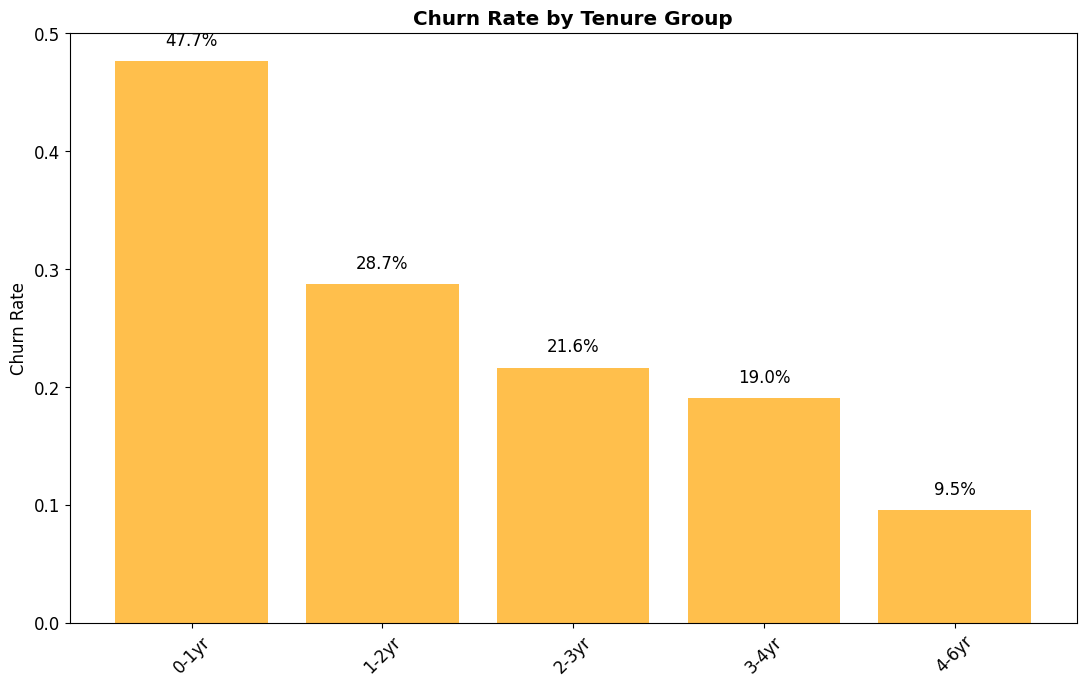

In [20]:
# 4. Tenure vs Churn Rate Analysis
# Create tenure groups
df_eda['TenureGroup'] = pd.cut(df_eda['tenure'], bins=[0, 12, 24, 36, 48, 72],
                               labels=['0-1yr', '1-2yr', '2-3yr', '3-4yr', '4-6yr'])
tenure_group_churn = df_eda.groupby('TenureGroup')['Churn_Binary'].mean()
bars = plt.bar(range(len(tenure_group_churn)), tenure_group_churn.values, alpha=0.7, color='orange')
plt.title('Churn Rate by Tenure Group', fontweight='bold')
plt.ylabel('Churn Rate')
plt.xticks(range(len(tenure_group_churn)), tenure_group_churn.index, rotation=45)
for i, (bar, rate) in enumerate(zip(bars, tenure_group_churn.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

plt.tight_layout(pad=4.0)
plt.show()

4️⃣ Analyzing Service Bundles...


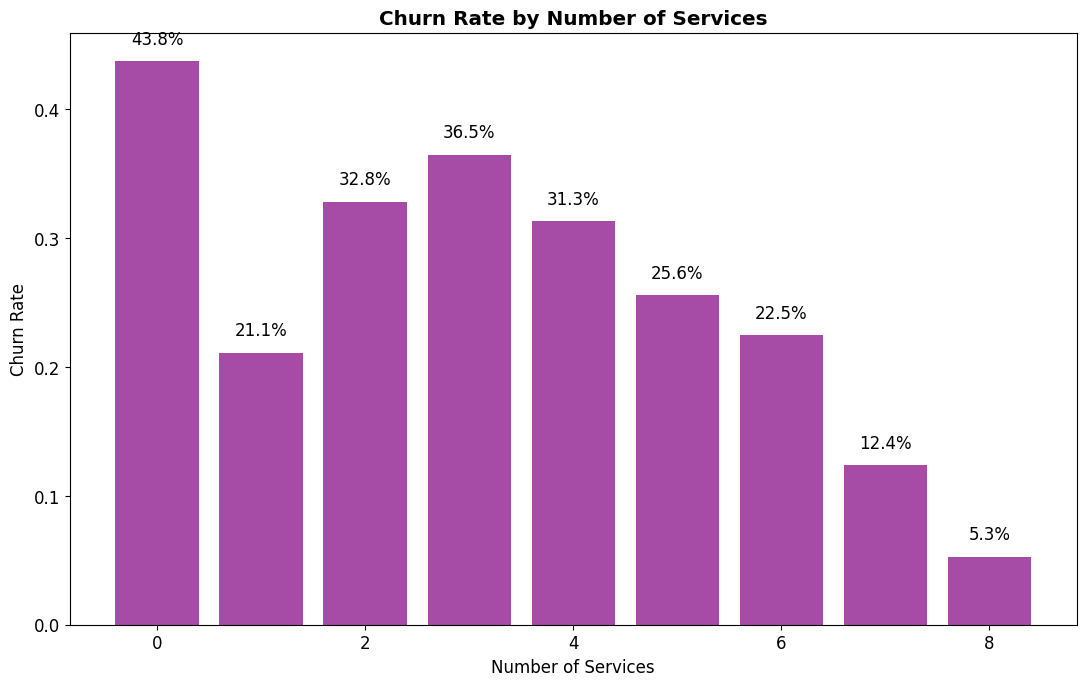

In [22]:
# 5. Service Bundle Analysis
print(f"4️⃣ Analyzing Service Bundles...")

# Count number of services per customer
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df_eda['ServiceCount'] = 0
for col in service_cols:
    df_eda['ServiceCount'] += (df_eda[col] == 'Yes').astype(int)

service_count_churn = df_eda.groupby('ServiceCount')['Churn_Binary'].mean()
bars = plt.bar(service_count_churn.index, service_count_churn.values, alpha=0.7, color='purple')
plt.title('Churn Rate by Number of Services', fontweight='bold')
plt.xlabel('Number of Services')
plt.ylabel('Churn Rate')
for bar, rate in zip(bars, service_count_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom')

plt.tight_layout(pad=4.0)
plt.show()

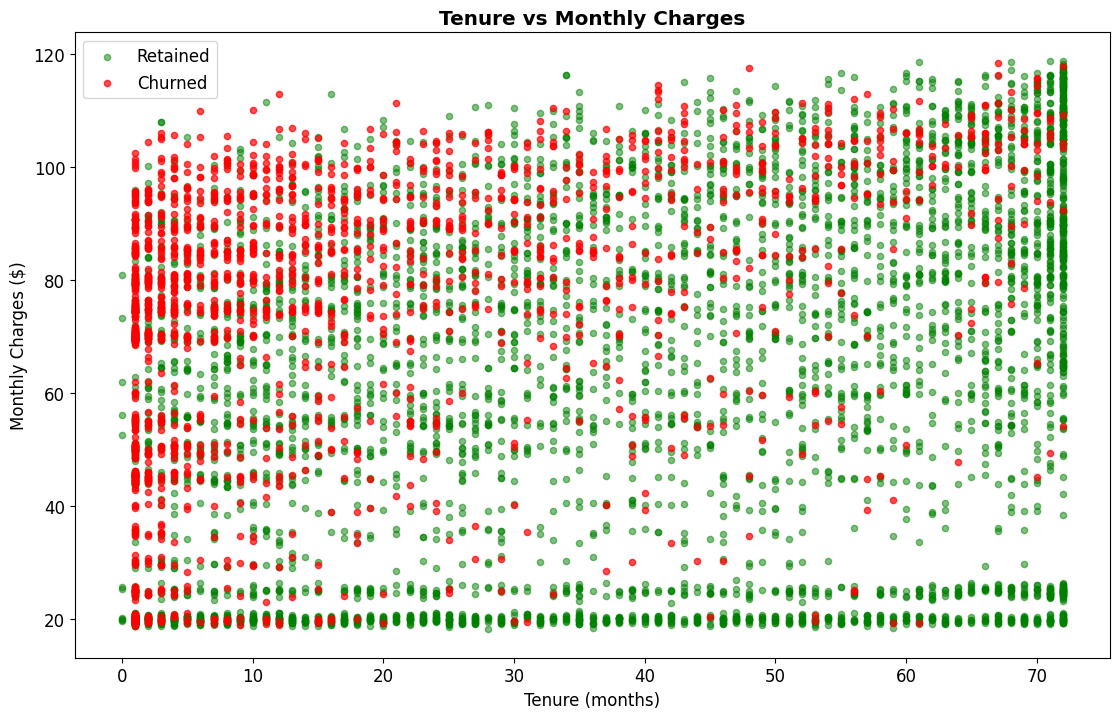

In [23]:
# 6. Monthly Charges vs Tenure Scatter
churned_customers = df_eda[df_eda['Churn'] == 'Yes']
retained_customers = df_eda[df_eda['Churn'] == 'No']
plt.scatter(retained_customers['tenure'], retained_customers['MonthlyCharges'],
           alpha=0.5, color='green', label='Retained', s=20)
plt.scatter(churned_customers['tenure'], churned_customers['MonthlyCharges'],
           alpha=0.7, color='red', label='Churned', s=20)
plt.title('Tenure vs Monthly Charges', fontweight='bold')
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges ($)')
plt.legend()
plt.tight_layout(pad=3.0)
plt.show()

Text(0.5, 1.0, 'Feature Correlation Matrix')

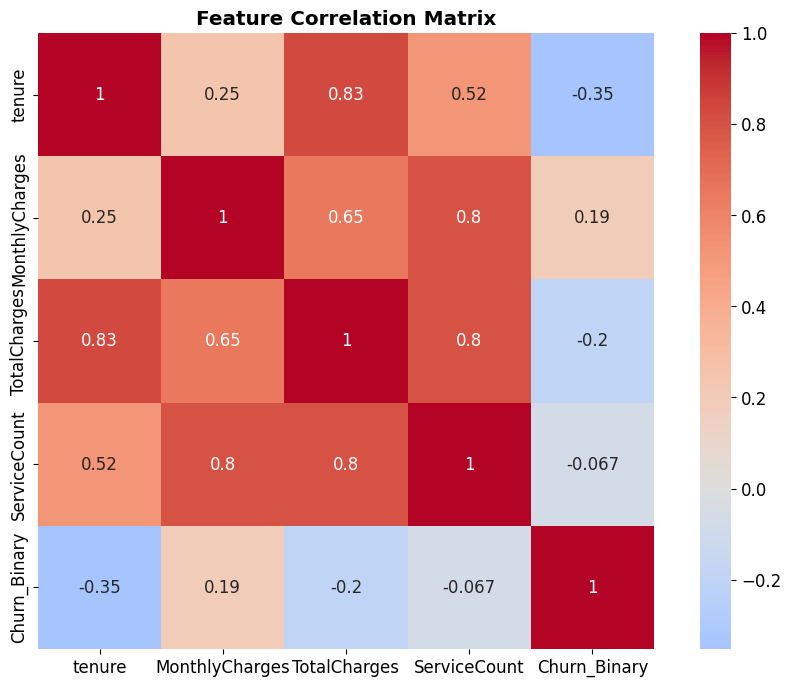

In [24]:
# 7. Correlation Heatmap
# Create correlation matrix for key numerical variables
corr_data = df_eda[['tenure', 'MonthlyCharges', 'TotalCharges', 'ServiceCount', 'Churn_Binary']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix', fontweight='bold')

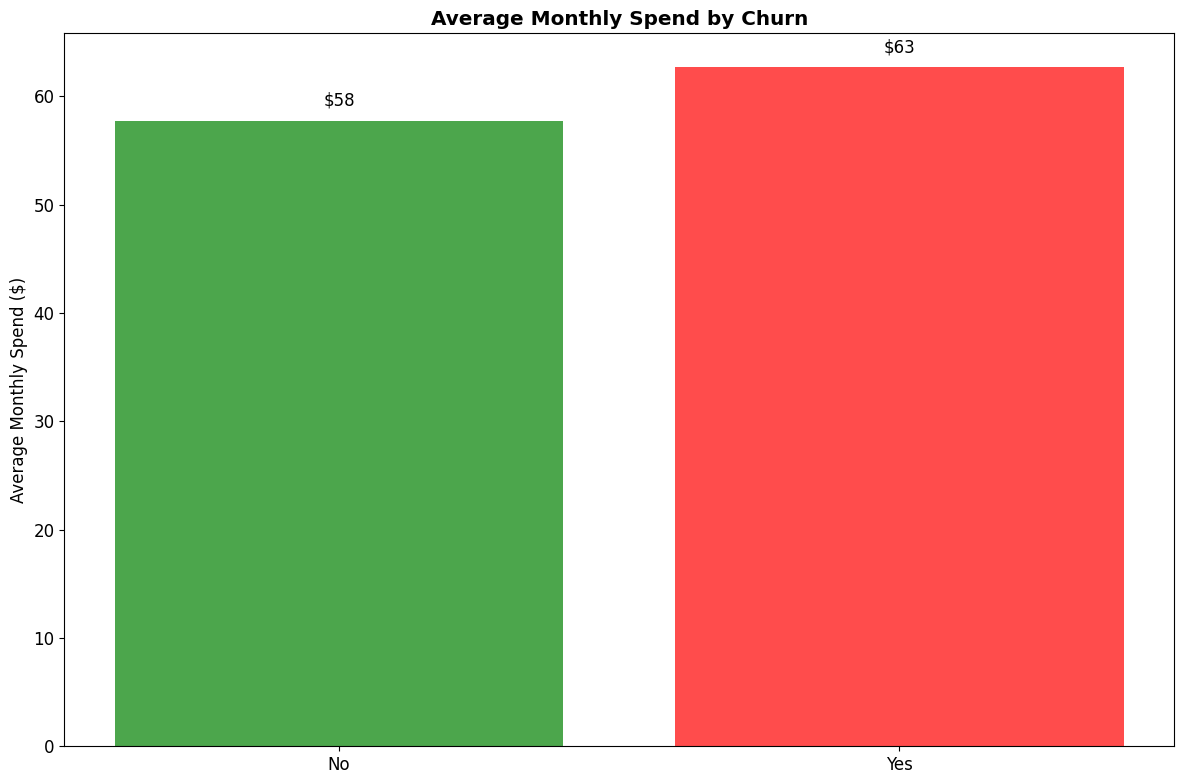

In [26]:
# 8. Customer Lifetime Value Analysis
df_eda['AvgMonthlySpend'] = df_eda['TotalCharges'] / (df_eda['tenure'] + 1)  # +1 to avoid division by zero
avg_spend_churn = df_eda.groupby('Churn')['AvgMonthlySpend'].mean()
bars = plt.bar(avg_spend_churn.index, avg_spend_churn.values, alpha=0.7, color=['green', 'red'])
plt.title('Average Monthly Spend by Churn', fontweight='bold')
plt.ylabel('Average Monthly Spend ($)')
for bar, spend in zip(bars, avg_spend_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'${spend:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [27]:
# Print key insights
print(f"\n💡 KEY BUSINESS INSIGHTS:")
print(f"=" * 50)

print(f"📊 Demographics:")
print(f"   • Senior citizens churn at {senior_churn[1]:.1%} vs {senior_churn[0]:.1%} for regular customers")
print(f"   • Customers without partners: {partner_churn['No']:.1%} vs with partners: {partner_churn['Yes']:.1%}")
print(f"   • Customers without dependents: {dependents_churn['No']:.1%} vs with dependents: {dependents_churn['Yes']:.1%}")

print(f"\n🔧 Service & Contract Insights:")
print(f"   • Month-to-month contracts: {contract_churn.iloc[0]:.1%} churn rate (HIGHEST RISK!)")
print(f"   • Two-year contracts: {contract_churn.iloc[2]:.1%} churn rate (LOWEST RISK)")
print(f"   • Fiber optic internet: {internet_churn.loc['Fiber optic']:.1%} churn rate")

print(f"\n💰 Financial Patterns:")
mean_tenure_churned = df_eda[df_eda['Churn'] == 'Yes']['tenure'].mean()
mean_tenure_retained = df_eda[df_eda['Churn'] == 'No']['tenure'].mean()
print(f"   • Average tenure (churned): {mean_tenure_churned:.1f} months")
print(f"   • Average tenure (retained): {mean_tenure_retained:.1f} months")

mean_charges_churned = df_eda[df_eda['Churn'] == 'Yes']['MonthlyCharges'].mean()
mean_charges_retained = df_eda[df_eda['Churn'] == 'No']['MonthlyCharges'].mean()
print(f"   • Average monthly charges (churned): ${mean_charges_churned:.0f}")
print(f"   • Average monthly charges (retained): ${mean_charges_retained:.0f}")

print(f"\n🎯 STRATEGIC RECOMMENDATIONS:")
print(f"   1. Focus retention efforts on month-to-month customers")
print(f"   2. Investigate fiber optic service quality issues")
print(f"   3. Create family/partner incentives for single customers")
print(f"   4. Develop senior citizen retention programs")
print(f"   5. Consider pricing strategies for high-charge customers")

# Calculate business impact
total_customers = len(df_eda)
churned_customers = (df_eda['Churn'] == 'Yes').sum()
avg_monthly_revenue = df_eda['MonthlyCharges'].mean()
annual_churn_loss = churned_customers * avg_monthly_revenue * 12

print(f"\n💸 BUSINESS IMPACT CALCULATION:")
print(f"   • Total customers: {total_customers:,}")
print(f"   • Churned customers: {churned_customers:,}")
print(f"   • Average monthly revenue per customer: ${avg_monthly_revenue:.0f}")
print(f"   • Estimated annual revenue loss: ${annual_churn_loss:,.0f}")
print(f"   • Potential savings with 50% churn reduction: ${annual_churn_loss/2:,.0f}")

print(f"\n✅ EDA completed! Ready for feature engineering...")


💡 KEY BUSINESS INSIGHTS:
📊 Demographics:
   • Senior citizens churn at 41.7% vs 23.6% for regular customers
   • Customers without partners: 33.0% vs with partners: 19.7%
   • Customers without dependents: 31.3% vs with dependents: 15.5%

🔧 Service & Contract Insights:
   • Month-to-month contracts: 42.7% churn rate (HIGHEST RISK!)
   • Two-year contracts: 2.8% churn rate (LOWEST RISK)
   • Fiber optic internet: 41.9% churn rate

💰 Financial Patterns:
   • Average tenure (churned): 18.0 months
   • Average tenure (retained): 37.6 months
   • Average monthly charges (churned): $74
   • Average monthly charges (retained): $61

🎯 STRATEGIC RECOMMENDATIONS:
   1. Focus retention efforts on month-to-month customers
   2. Investigate fiber optic service quality issues
   3. Create family/partner incentives for single customers
   4. Develop senior citizen retention programs
   5. Consider pricing strategies for high-charge customers

💸 BUSINESS IMPACT CALCULATION:
   • Total customers: 7,04